In [1]:
import pandas as pd

# Load the dataset from the GitHub repository
url = 'https://raw.githubusercontent.com/gregversteeg/LinearCorex/master/tests/data/test_big5.csv'
df = pd.read_csv(url)

# Display basic information about the dataset
print("Number of instances in the dataset:", df.shape[0])
print("Number of columns in the dataset:", df.shape[1])
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Display additional information
print("\nData Types and Non-Null Counts:")
print(df.info())

Number of instances in the dataset: 2000
Number of columns in the dataset: 50

First 5 rows of the dataset:
   blue_q0  red_q1  green_q2  purple_q3  q4  blue_q5  red_q6  green_q7  \
0        2       0         3          1   4        1       4         1   
1        2       0         1          2   2        1       4         3   
2        3       0         2          1   3        1       4         3   
3        2       0         1          1   1        0       4         1   
4        2       0         1          1   3        0       4         3   

   purple_q8  q9  ...  blue_q40  red_q41  green_q42  purple_q43  q44  \
0          2   2  ...         3        3          3           2    3   
1          3   1  ...         2        3          2           2    3   
2          3   0  ...         4        4          2           1    4   
3          3   1  ...         1        2          2           1    3   
4          2   0  ...         3        4          1           3    4   

   blue_q45  r

In [2]:
df = df / 4.0
# print(df.head())

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Split the data into features (X) and target (Y) if necessary.
# In the case of autoencoder-like models, we do not have target Y, so we'll treat the whole dataset as X.
X = df.values  # Convert the DataFrame into a NumPy array for model input

# Split the dataset into training (80%) and testing sets (20%)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Output the shapes to verify
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1600, 50)
Test set shape: (400, 50)


In [4]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert the DataFrame to a NumPy array
data_array = df.to_numpy()

# Convert the data to a PyTorch tensor
data_tensor = torch.tensor(data_array, dtype=torch.float32)

# Create a PyTorch dataset
dataset = TensorDataset(data_tensor)

# Split the dataset into training and validation sets (80-20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for the training and validation sets
batch_size = 32  # You can adjust the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Display the shape of the tensor to verify
print(f"Data tensor shape: {data_tensor.shape}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Data tensor shape: torch.Size([2000, 50])
Number of training batches: 50
Number of validation batches: 13


In [5]:
# Import necessary libraries
import torch
import torch.nn as nn

# Encoder class
class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim, hidden_dims=[]):
        super(Encoder, self).__init__()
        # Define the layers of the MLP
        dims = [input_dim] + hidden_dims + [output_dim]
        layers = []
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            if i < len(dims) - 2:
                layers.append(nn.ReLU())
        self.mlp = nn.Sequential(*layers)

        # Learnable embedding vectors e_i for each z_i
        self.e = nn.Parameter(torch.randn(output_dim, embedding_dim))
        self.embedding_dim = embedding_dim
        self.output_dim = output_dim

    def forward(self, x):
        # Pass the input through the MLP to get Z
        Z = self.mlp(x)  # Shape: (batch_size, output_dim)

        # Convert Z to \hat Z by multiplying each scalar z_i with its own embedding vector e_i
        batch_size = Z.size(0)
        Z_expanded = Z.unsqueeze(2)                         # Shape: (batch_size, output_dim, 1)
        e_expanded = self.e.unsqueeze(0)                    # Shape: (1, output_dim, embedding_dim)
        hat_Z = Z_expanded * e_expanded                     # Shape: (batch_size, output_dim, embedding_dim)

        return hat_Z

In [6]:
# Decoder class with individual MLPs for each observed variable
class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim, hidden_dims=[]):
        super(Decoder, self).__init__()
        self.input_dim = input_dim      # Number of observed variables (n)
        self.output_dim = output_dim    # Number of latent factors (k)
        self.embedding_dim = embedding_dim

        # Learnable matrix M of shape (input_dim, output_dim)
        self.M = nn.Parameter(torch.randn(input_dim, output_dim))

        # Value weight matrix W_v to transform \hat{Z} to V
        self.W_v = nn.Linear(embedding_dim, embedding_dim, bias=False)  # Optional bias

        # Define individual MLPs for each observed variable
        dims = [embedding_dim] + hidden_dims + [1]
        self.mlp_layers = nn.ModuleList([
            nn.Sequential(*[
                nn.Linear(dims[i], dims[i + 1]) if i == len(dims) - 2 else nn.Sequential(
                    nn.Linear(dims[i], dims[i + 1]),
                    nn.ReLU()
                )
                for i in range(len(dims) - 1)
            ])
            for _ in range(input_dim)
        ])

    def forward(self, hat_Z):
        """
        hat_Z: Tensor of shape (batch_size, output_dim, embedding_dim)
        """
        batch_size = hat_Z.size(0)

        # Compute value matrix V by applying W_v to \hat{Z}
        V = self.W_v(hat_Z)  # Shape: (batch_size, output_dim, embedding_dim)

        # Compute attention weights
        # Take absolute value of M and apply softmax over output_dim (latent factors) axis
        M_abs = torch.abs(self.M)  # Shape: (input_dim, output_dim)
        attention_weights = F.softmax(M_abs, dim=1)  # Shape: (input_dim, output_dim)

        # Expand attention weights to batch dimension
        attention_weights = attention_weights.unsqueeze(0).expand(batch_size, -1, -1)  # Shape: (batch_size, input_dim, output_dim)

        # Compute context vectors for each observed variable
        # Multiply attention weights with V
        # Need to transpose V to (batch_size, embedding_dim, output_dim)
        V_transposed = V.permute(0, 2, 1)  # Shape: (batch_size, embedding_dim, output_dim)
        context = torch.bmm(attention_weights, V_transposed.transpose(1, 2))  # Shape: (batch_size, input_dim, embedding_dim)

        # Pass each context vector through its corresponding MLP
        x_hat = []
        for i in range(self.input_dim):
            x_i = context[:, i, :]  # Shape: (batch_size, embedding_dim)
            x_i_hat = self.mlp_layers[i](x_i)  # Shape: (batch_size, 1)
            x_hat.append(x_i_hat)
        x_hat = torch.cat(x_hat, dim=1)  # Shape: (batch_size, input_dim)

        return x_hat, attention_weights  # Return attention weights for potential analysis


In [7]:
# Complete model combining the encoder and decoder
class Model(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim, encoder_hidden_dims=[], decoder_hidden_dims=[]):
        super(Model, self).__init__()
        self.encoder = Encoder(
            input_dim=input_dim,
            output_dim=output_dim,
            embedding_dim=embedding_dim,
            hidden_dims=encoder_hidden_dims
        )
        self.decoder = Decoder(
            input_dim=input_dim,
            output_dim=output_dim,
            embedding_dim=embedding_dim,
            hidden_dims=decoder_hidden_dims
        )

    def forward(self, x):
        hat_Z = self.encoder(x)     # Obtain \hat{Z} from the encoder
        x_hat, attention_weights = self.decoder(hat_Z)  # Reconstruct x from \hat{Z} using the decoder
        return x_hat, attention_weights

In [8]:
import os
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Assume that the Encoder, Decoder, and Model classes are already defined

# Define dimensions
input_dim = 50        # Number of observed variables
output_dim = 5        # Output dimension of the encoder (dimension of Z)
embedding_dim = 64    # Embedding dimension for the embeddings e and e_i's
encoder_hidden_dims = [128, 64]  # Hidden dimensions for the encoder
decoder_hidden_dims = [64, 32]   # Hidden dimensions for the decoder

# Instantiate the model
model = Model(
    input_dim=input_dim,
    output_dim=output_dim,
    embedding_dim=embedding_dim,
    encoder_hidden_dims=encoder_hidden_dims,
    decoder_hidden_dims=decoder_hidden_dims
)

# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 25          # Number of epochs
batch_size = 32          # Batch size (already set in the DataLoader)
print_every = 1          # How often to print loss (in epochs)

# Define the maximum value for the entropy regularization coefficient
max_lambda_entropy = 1e-3  # Adjust this value as needed

# Flag to enable or disable entropy regularizer
use_entropy_regularizer = True  # Set to True to enable, False to disable

# Scheduler function for lambda_entropy
def get_lambda_entropy(epoch, num_epochs, max_lambda_entropy, schedule_type='exponential', use_entropy_regularizer=True):
    if not use_entropy_regularizer:
        return 0.0
    if schedule_type == 'constant':
        # Always return max_lambda_entropy
        return max_lambda_entropy
    elif schedule_type == 'linear':
        # Linear increase from 0 to max_lambda_entropy
        return max_lambda_entropy * (epoch / num_epochs)
    elif schedule_type == 'exponential':
        # Exponential increase from 0 to max_lambda_entropy
        k = 5  # Adjust this value to control the speed of increase
        return max_lambda_entropy * (1 - math.exp(-k * epoch / num_epochs))
    elif schedule_type == 'logarithmic':
        # Logarithmic increase from 0 to max_lambda_entropy
        if epoch == 0:
            return 0.0
        else:
            return max_lambda_entropy * math.log(epoch + 1) / math.log(num_epochs + 1)
    else:
        raise ValueError(f"Unknown schedule_type: {schedule_type}")

model_path = "trained_model.pth"
if os.path.exists(model_path):
    print("Trained model found. Loading the model.")
    model.load_state_dict(torch.load(model_path))
    print("Model loaded successfully!")

# Initialize a list to store the average attention matrices per epoch
attention_matrices = []

# Training loop with validation
for epoch in range(num_epochs):
    # Compute lambda_entropy for the current epoch
    lambda_entropy = get_lambda_entropy(
        epoch, num_epochs, max_lambda_entropy, schedule_type='exponential', use_entropy_regularizer=use_entropy_regularizer)

    # Training phase
    model.train()
    running_loss = 0.0          # Accumulates total loss (reconstruction + regularizer)
    running_recon_loss = 0.0    # Accumulates reconstruction loss
    epoch_attn_weights = []     # List to store attention weights for all batches in the epoch

    for batch_idx, (batch,) in enumerate(train_loader):
        batch = batch.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: Compute predicted x_hat and attention weights
        x_hat, attn_weights = model(batch)

        # Squeeze attn_weights to get shape: (batch_size, input_dim, output_dim)
        attn_weights = attn_weights.squeeze(1)

        # Collect attention weights for the epoch
        epoch_attn_weights.append(attn_weights.detach().cpu())

        # Compute the reconstruction loss
        recon_loss = criterion(x_hat, batch)

        # Initialize entropy_regularizer to zero
        entropy_regularizer = 0.0

        # Compute the entropy regularizer if enabled
        if use_entropy_regularizer:
            # Add a small epsilon to prevent log(0)
            epsilon = 1e-8

            # Compute entropy for each query (input_dim)
            entropy = -torch.sum(attn_weights * torch.log(attn_weights + epsilon), dim=2)  # Shape: (batch_size, input_dim)

            # Sum entropies over queries and average over batch
            entropy_regularizer = torch.mean(torch.sum(entropy, dim=1))  # Scalar

        # Total loss
        loss = recon_loss + lambda_entropy * entropy_regularizer

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate training losses
        running_loss += loss.item()
        running_recon_loss += recon_loss.item()

    # Compute average losses for training
    avg_train_loss = running_loss / len(train_loader)
    avg_train_recon_loss = running_recon_loss / len(train_loader)

    # Compute the average attention matrix for the epoch
    epoch_attn_weights_tensor = torch.cat(epoch_attn_weights, dim=0)  # Shape: (num_samples_in_epoch, input_dim, output_dim)
    avg_attn_weights_epoch = epoch_attn_weights_tensor.mean(dim=0)    # Shape: (input_dim, output_dim)
    avg_attn_weights_epoch_np = avg_attn_weights_epoch.numpy()

    # Transpose to have shape (output_dim, input_dim) so that queries are on x-axis and keys on y-axis
    attention_matrices.append(avg_attn_weights_epoch_np.T)

    # Validation phase
    model.eval()
    val_loss = 0.0          # Accumulates total loss (reconstruction + regularizer)
    val_recon_loss = 0.0    # Accumulates reconstruction loss
    with torch.no_grad():
        for batch_idx, (batch,) in enumerate(val_loader):
            batch = batch.to(device)

            # Forward pass for validation
            x_hat, attn_weights = model(batch)

            # Compute the reconstruction loss
            recon_loss = criterion(x_hat, batch)

            # Initialize entropy_regularizer to zero
            entropy_regularizer = 0.0

            # Compute the entropy regularizer if enabled
            if use_entropy_regularizer:
                attn_weights = attn_weights.squeeze(1)  # Shape: (batch_size, input_dim, output_dim)

                # Add a small epsilon to prevent log(0)
                epsilon = 1e-8

                # Compute entropy for each query (input_dim)
                entropy = -torch.sum(attn_weights * torch.log(attn_weights + epsilon), dim=2)  # Shape: (batch_size, input_dim)

                # Sum entropies over queries and average over batch
                entropy_regularizer = torch.mean(torch.sum(entropy, dim=1))  # Scalar

            # Total loss
            loss = recon_loss + lambda_entropy * entropy_regularizer

            # Accumulate validation losses
            val_loss += loss.item()
            val_recon_loss += recon_loss.item()

    # Compute average losses for validation
    avg_val_loss = val_loss / len(val_loader)
    avg_val_recon_loss = val_recon_loss / len(val_loader)

    # Print average losses for the epoch
    if (epoch + 1) % print_every == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Lambda Entropy: {lambda_entropy:.6f}, '
              f'Train Total Loss: {avg_train_loss:.4f}, Train Recon Loss: {avg_train_recon_loss:.4f}, '
              f'Val Total Loss: {avg_val_loss:.4f}, Val Recon Loss: {avg_val_recon_loss:.4f}')

# # Save the trained model after training
# torch.save(model.state_dict(), "trained_model.pth")
# print("Training complete and model saved.")


Epoch [1/25], Lambda Entropy: 0.000000, Train Total Loss: 0.1479, Train Recon Loss: 0.1479, Val Total Loss: 0.0854, Val Recon Loss: 0.0854
Epoch [2/25], Lambda Entropy: 0.000181, Train Total Loss: 0.0991, Train Recon Loss: 0.0858, Val Total Loss: 0.0959, Val Recon Loss: 0.0826
Epoch [3/25], Lambda Entropy: 0.000330, Train Total Loss: 0.1020, Train Recon Loss: 0.0779, Val Total Loss: 0.0934, Val Recon Loss: 0.0694
Epoch [4/25], Lambda Entropy: 0.000451, Train Total Loss: 0.0976, Train Recon Loss: 0.0647, Val Total Loss: 0.0931, Val Recon Loss: 0.0604
Epoch [5/25], Lambda Entropy: 0.000551, Train Total Loss: 0.0988, Train Recon Loss: 0.0589, Val Total Loss: 0.0965, Val Recon Loss: 0.0567
Epoch [6/25], Lambda Entropy: 0.000632, Train Total Loss: 0.1015, Train Recon Loss: 0.0559, Val Total Loss: 0.0996, Val Recon Loss: 0.0541
Epoch [7/25], Lambda Entropy: 0.000699, Train Total Loss: 0.1033, Train Recon Loss: 0.0531, Val Total Loss: 0.1018, Val Recon Loss: 0.0518
Epoch [8/25], Lambda Entrop

In [9]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import adjusted_rand_score

# Step 1: Extract the attention matrix M from the trained model
# Assuming 'model' is your trained model instance
M = model.decoder.M.data.cpu().numpy()  # Shape: (input_dim, output_dim)

# Step 2: Compute the attention weights
# Take the absolute value of M
M_abs = np.abs(M)  # Shape: (input_dim, output_dim)

# Convert to tensor for softmax computation
M_abs_tensor = torch.tensor(M_abs, dtype=torch.float32)

# Apply softmax over the output_dim axis (dim=1)
attention_weights_tensor = F.softmax(M_abs_tensor, dim=1)  # Shape: (input_dim, output_dim)

# Convert back to NumPy array
attention_weights = attention_weights_tensor.numpy()

# Step 3: Assign each observed variable to the latent factor with the highest attention weight
predicted_labels = np.argmax(attention_weights, axis=1)  # Shape: (input_dim,)

# Step 4: Create true labels for the observed variables
# Assuming 'df' is your DataFrame containing the observed variables with their names

# Identify column prefixes for each true factor
factor_columns = {
    'Factor0': [col for col in df.columns if col.startswith('blue')],
    'Factor1': [col for col in df.columns if col.startswith('green')],
    'Factor2': [col for col in df.columns if col.startswith('purple')],
    'Factor3': [col for col in df.columns if col.startswith('red')],
    'Factor4': [col for col in df.columns if col.startswith('q')]
}

# Map factor names to column indices
factor_indices = {}
for factor_name, columns in factor_columns.items():
    indices = [df.columns.get_loc(col) for col in columns]
    factor_indices[factor_name] = indices

# Create true labels for variables
n_features = df.shape[1]
true_labels = np.full(n_features, -1)  # Initialize with -1

factor_names = ['Factor0', 'Factor1', 'Factor2', 'Factor3', 'Factor4']
factor_name_to_index = {name: idx for idx, name in enumerate(factor_names)}

for factor_name, indices in factor_indices.items():
    factor_idx = factor_name_to_index[factor_name]
    true_labels[indices] = factor_idx

# Ensure all variables have been assigned
assert np.all(true_labels >= 0), "Some variables have not been assigned a true label"

# Step 5: Compute the Adjusted Rand Index
ari = adjusted_rand_score(true_labels, predicted_labels)
print(f'Adjusted Rand Index (ARI): {ari:.4f}')


Adjusted Rand Index (ARI): -0.0029


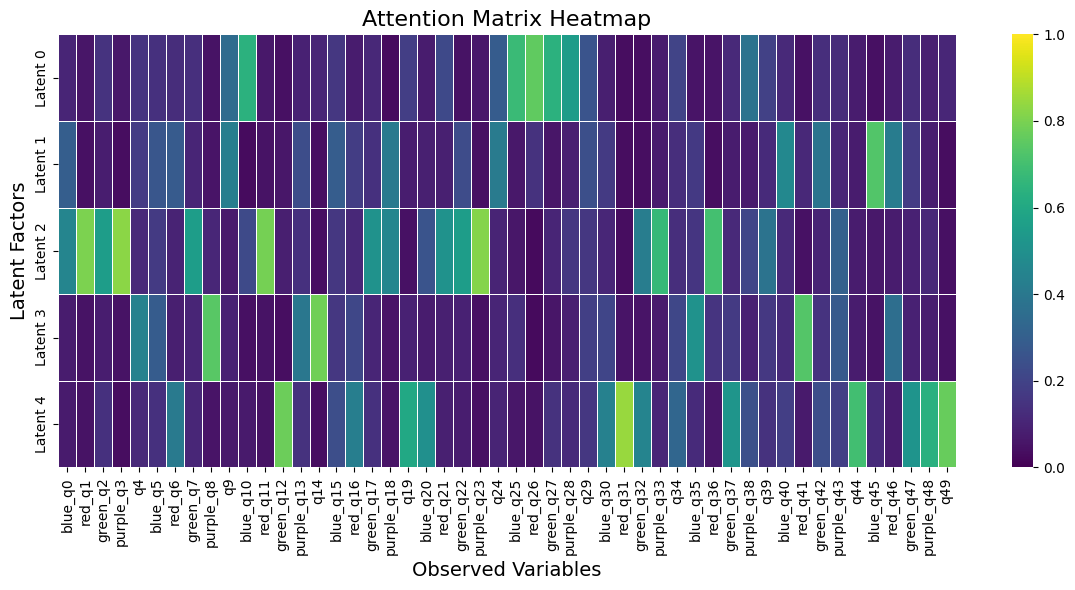

In [10]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Extract the attention matrix M from the trained model
# Assuming 'model' is your trained model instance
M = model.decoder.M.data.cpu().numpy()  # Shape: (input_dim, output_dim)

# Step 2: Compute the attention weights
# Take the absolute value of M
M_abs = np.abs(M)  # Shape: (input_dim, output_dim)

# Apply softmax over the output_dim axis (dim=1)
M_abs_tensor = torch.tensor(M_abs, dtype=torch.float32)
attention_weights_tensor = F.softmax(M_abs_tensor, dim=1)
attention_weights = attention_weights_tensor.numpy()

# Step 3: Transpose the attention weights to have latent factors along y-axis and observed variables along x-axis
attention_matrix = attention_weights.T  # Shape: (output_dim, input_dim)

# Step 4: Prepare labels for observed variables and latent factors
# Assuming 'df' is your DataFrame containing the observed variables with their names
observed_variable_names = df.columns.tolist()  # List of observed variable names
latent_factor_names = [f'Latent {i}' for i in range(attention_matrix.shape[0])]  # Latent factor names

# Step 5: Create a DataFrame for visualization
attention_df = pd.DataFrame(
    attention_matrix,
    index=latent_factor_names,
    columns=observed_variable_names
)

# Step 6: Plot the attention matrix heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    attention_df,
    cmap='viridis',
    linewidths=0.5,
    annot=False,
    cbar=True,
    vmin=0,
    vmax=1
)
plt.title('Attention Matrix Heatmap', fontsize=16)
plt.xlabel('Observed Variables', fontsize=14)
plt.ylabel('Latent Factors', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
